In [1]:
# Import
import torch
import torch.nn as nn
import numpy as np
from dataloader import BatchDataloader
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from utils import pgd_attack, eval_loop, eval_loop_apgd, filter_adversarial
from models import ResNet1dGELU
import ecg_plot
from utils import plot_ecgs
import ast
%matplotlib inline

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

Use device: cuda



In [3]:
# hyperparameters
batch_size = 32

In [5]:
# Load the data
dataset_path = '/local_storage/users/arveri/code-15'

path_to_csv = dataset_path + '/exams.csv'
path_to_val = dataset_path + '/test.h5'

# Get labels
df = pd.read_csv(path_to_csv, index_col='exam_id')

# Get h5 file
h5_file = h5py.File(path_to_val, 'r')
traces_ids = h5_file['exam_id']

# Only keep the traces in the csv that match the traces in the h5 file
df = df[df.index.isin(traces_ids)]

# Define traces
traces = h5_file['tracings']

# Sort the dataframe in trace order
df = df.reindex(traces_ids)

# Get labels afib
labels = df['AF'].values

# Get labels age
# labels = df['is_male'].values
# labels = 1 - labels

# Count each label
unique, counts = np.unique(labels, return_counts=True)

# Print it
print(dict(zip(unique, counts)))

# Make into torch tensor
labels = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)

# Take the first 2000 samples
# traces = traces[:2000]
# labels = labels[:2000]

# Define dataloaders
val_dataloader = BatchDataloader(traces, labels, batch_size=batch_size)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../code-15/test.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [2]:
model_paths = ["../models/afib/ptb_20_code15ft_lr1e-4_div1/latest.pth",
               "../models/afib/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1/latest.pth",
               "../models/afib/ptb_20_apgd_5e-2_code15ft_lr1e-4_div1/latest.pth",
               "../models/afib/code_10/latest.pth"]

In [6]:
loss_function = nn.BCEWithLogitsLoss()

for model_path in model_paths:
    # Define the model
    model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)

    valid_loss, y_pred, y_true = eval_loop_apgd(0, val_dataloader, model, loss_function, device)

    # save y_pred and y_true to same directory as model
    path = model_path.split('.pth')[0]

    with open(path + '_y_pred.npy', 'wb') as f:
        np.save(f, y_pred)
    with open(path + '_y_true.npy', 'wb') as f:
        np.save(f, y_true)

Evaluation Epoch  0:   0%|          | 0/1078 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/1078 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/1078 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/1078 [00:00<?, ?it/s]

In [3]:
n_boot = 500

In [8]:
# Create dictionary for storing metrics for each model
metrics = {}

# Evaluate using the saved y_pred and y_true
for model_path in model_paths:
    path = model_path.split('.pth')[0]
    
    with open(path + '_y_pred.npy', 'rb') as f:
        y_pred = np.load(f)
    with open(path + '_y_true.npy', 'rb') as f:
        y_true = np.load(f)
        
    # apply sigmoid to y_pred
    y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()
    
    auroc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    
    # bootstrap for auroc, ap and max f1
    auroc_boot = np.zeros(n_boot)
    ap_boot = np.zeros(n_boot)
    
    for i in range(n_boot):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        auroc_boot[i] = roc_auc_score(y_true[indices], y_pred[indices])
        ap_boot[i] = average_precision_score(y_true[indices], y_pred[indices])
    
    y_pred = np.round(y_pred)
    
    # compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # bootstarp for accuracy
    accuracy_boot = np.zeros(n_boot)
    
    for i in range(n_boot):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        accuracy_boot[i] = accuracy_score(y_true[indices], y_pred[indices])
    
    # Get q1, q3 and median for each metric
    auroc_q1, auroc_q3 = np.quantile(auroc_boot, [0.25, 0.75])
    ap_q1, ap_q3 = np.quantile(ap_boot, [0.25, 0.75])
    accuracy_q1, accuracy_q3 = np.quantile(accuracy_boot, [0.25, 0.75])
    
    auroc_median = np.median(auroc_boot)
    ap_median = np.median(ap_boot)
    accuracy_median = np.median(accuracy_boot)
    
    # store the metrics for this model
    metrics[model_path] = {'auroc': auroc, 'auroc_q1': auroc_q1, 'auroc_q3': auroc_q3, 'auroc_median': auroc_median,
                           'ap': ap, 'ap_q1': ap_q1, 'ap_q3': ap_q3, 'ap_median': ap_median,
                           'accuracy': accuracy, 'accuracy_q1': accuracy_q1, 'accuracy_q3': accuracy_q3, 'accuracy_median': accuracy_median,}

In [9]:
# Print table comparing results
from tabulate import tabulate

table = []

metric = 'ap'

for model_path, model_metrics in metrics.items():
    table.append([model_path, model_metrics[metric + '_median'], model_metrics[metric + '_q1'], model_metrics[metric + '_q3'], model_metrics[metric]])

print(tabulate(table, headers=['Model', 'Median', 'Q1', 'Q3', 'Value']))

Model                                                              Median        Q1        Q3     Value
---------------------------------------------------------------  --------  --------  --------  --------
../models/afib/ptb_20_code15ft_lr1e-4_div1/latest.pth            0.685905  0.672576  0.697977  0.684693
../models/afib/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1/latest.pth  0.733343  0.721433  0.745333  0.73247
../models/afib/ptb_20_apgd_5e-2_code15ft_lr1e-4_div1/latest.pth  0.685071  0.670685  0.697905  0.684437
../models/afib/code_10/latest.pth                                0.686341  0.673076  0.699746  0.685266


In [ ]:
# Evaluate for different epsilon values
eps_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

for model_path in model_paths:
    # Define the model
    model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    
    for eps in eps_list:
        valid_loss, y_pred, y_true = eval_loop_apgd(0, val_dataloader, model, loss_function, device, True, eps, adv_iters=10, adv_restarts=1)

        # save y_pred and y_true to same directory as model
        path = model_path.split('.pth')[0]

        with open(path + f'_y_pred_eps_{eps}.npy', 'wb') as f:
            np.save(f, y_pred)
        with open(path + f'_y_true_eps_{eps}.npy', 'wb') as f:
            np.save(f, y_true)

In [8]:
eps_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# Create dictionary for storing metrics for each model
eps_metrics = {}

# Evaluate using the saved y_pred and y_true
for model_path in model_paths:
    path = model_path.split('.pth')[0]
    
    for eps in eps_list:
        with open(path + f'_y_pred_eps_{eps}.npy', 'rb') as f:
            y_pred = np.load(f)
        with open(path + f'_y_true_eps_{eps}.npy', 'rb') as f:
            y_true = np.load(f)
        
        # apply sigmoid to y_pred
        y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()
        
        auroc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
        
        # bootstrap for auroc, ap and max f1
        auroc_boot = np.zeros(n_boot)
        ap_boot = np.zeros(n_boot)
        
        for i in range(n_boot):
            indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
            auroc_boot[i] = roc_auc_score(y_true[indices], y_pred[indices])
            ap_boot[i] = average_precision_score(y_true[indices], y_pred[indices])
        
        y_pred = np.round(y_pred)
        
        # compute accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # bootstarp for accuracy
        accuracy_boot = np.zeros(n_boot)
        
        for i in range(n_boot):
            indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
            accuracy_boot[i] = accuracy_score(y_true[indices], y_pred[indices])
        
        # Get q1, q3 and median for each metric
        auroc_q1, auroc_q3, auroc_q975, aurocq025 = np.quantile(auroc_boot, [0.25, 0.75, 0.975, 0.025])
        ap_q1, ap_q3, ap_q975, ap_q025 = np.quantile(ap_boot, [0.25, 0.75, 0.975, 0.025])
        accuracy_q1, accuracy_q3, accuracy_q975, accuracy_q025 = np.quantile(accuracy_boot, [0.25, 0.75, 0.975, 0.025])
        
        auroc_median = np.median(auroc_boot)
        ap_median = np.median(ap_boot)
        accuracy_median = np.median(accuracy_boot)
        
        # store the metrics for this model
        if model_path not in eps_metrics:
            eps_metrics[model_path] = {}
        
        eps_metrics[model_path][eps] = {'auroc': auroc, 'auroc_q1': auroc_q1, 'auroc_q3': auroc_q3, 'auroc_median': auroc_median, 'auroc_q975': auroc_q975, 'auroc_q025': aurocq025,
                                   'ap': ap, 'ap_q1': ap_q1, 'ap_q3': ap_q3, 'ap_median': ap_median, 'ap_q975': ap_q975, 'ap_q025': ap_q025,
                                   'accuracy': accuracy, 'accuracy_q1': accuracy_q1, 'accuracy_q3': accuracy_q3, 'accuracy_median': accuracy_median, 'accuracy_q975': accuracy_q975, 'accuracy_q025': accuracy_q025}

In [9]:
# save eps_metrics
import json

with open('eps_metrics.json', 'w') as f:
    json.dump(eps_metrics, f)

In [6]:
# load eps_metrics
import json

with open('eps_metrics.json', 'r') as f:
    eps_metrics = json.load(f)

print(eps_metrics.keys())


dict_keys(['../models/afib/ptb_20_code15ft_lr1e-4_div1/latest.pth', '../models/afib/ptb_20_apgd_5e-2_code15ft_lr1e-4_div1/latest.pth', '../models/afib/ptb_20_apgd_1e-2_code15ft_lr1e-4_div1/latest.pth', '../models/afib/code_10/latest.pth'])


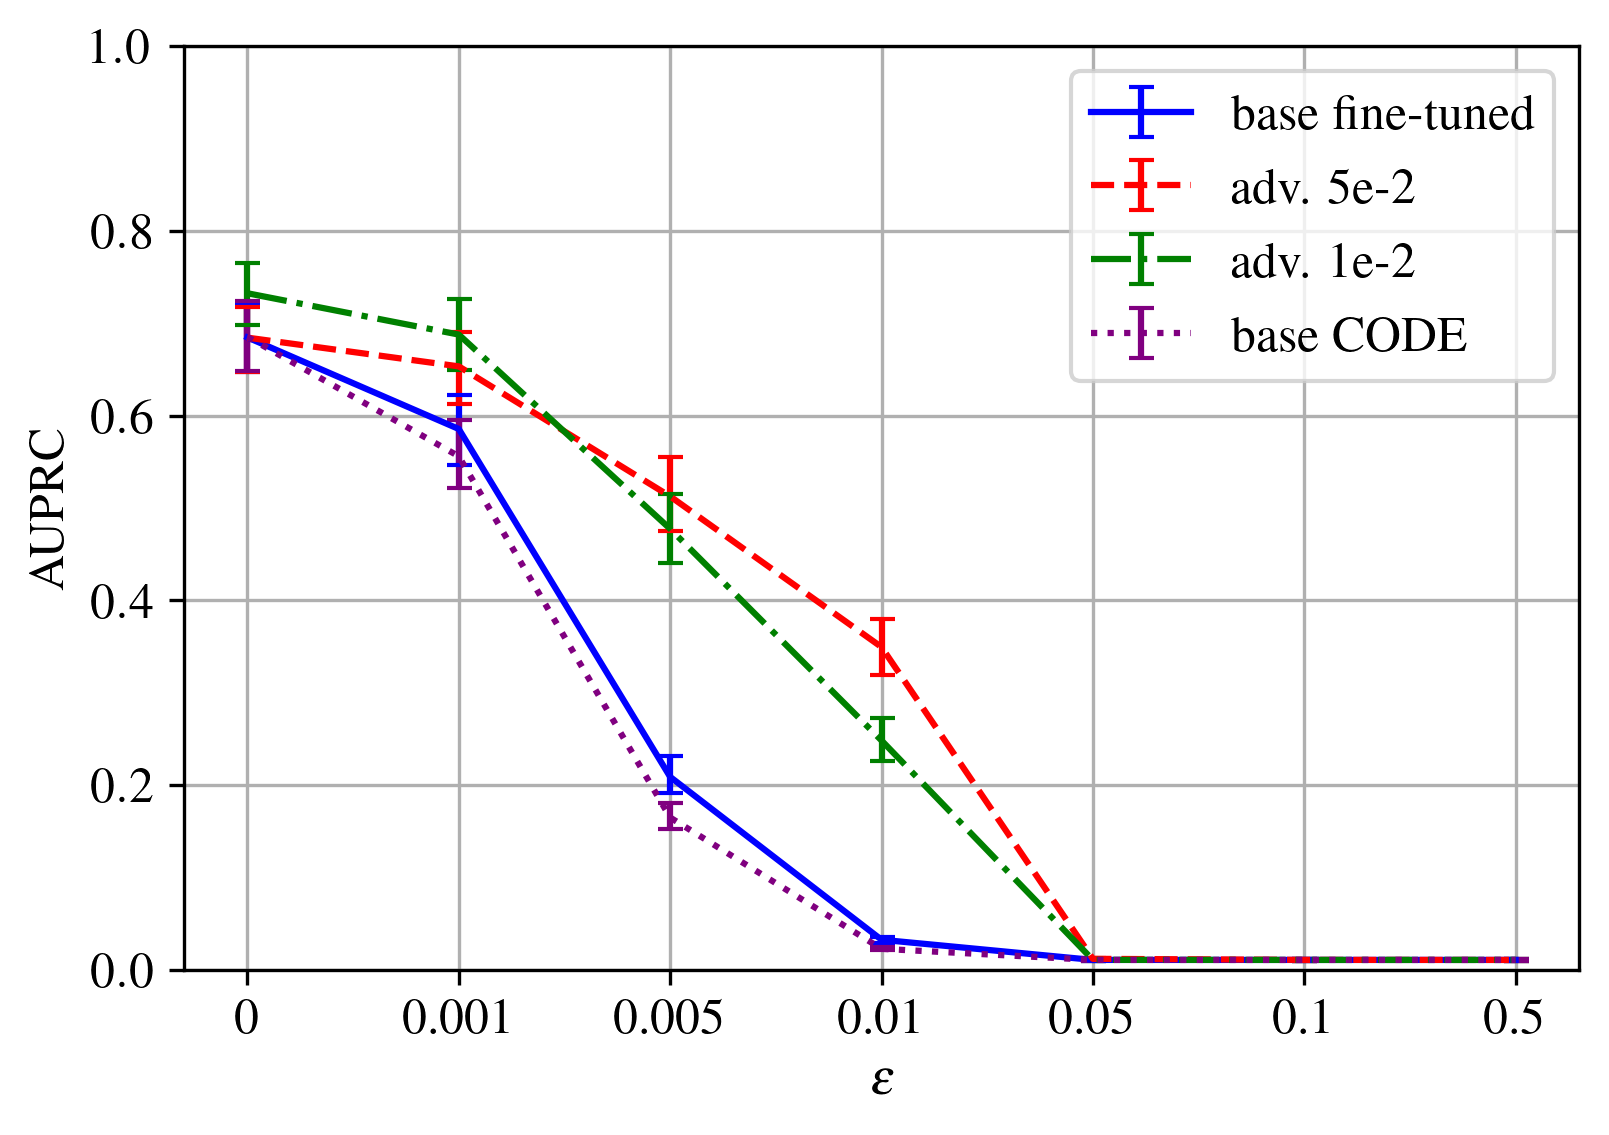

In [14]:
# Plot eps vs ap for each model
import matplotlib as mpl

plt.style.use(['../figures/style.mpl'])

labels = ["base fine-tuned", "adv. 5e-2", "adv. 1e-2", "base CODE"]
colors = ["blue", "red", "green", "purple"]
linestyles = ['-', '--', '-.', ':']

index = 0

for model_path, model_metrics in eps_metrics.items():
    aps = [metrics['ap'] for _, metrics in model_metrics.items()]
    aps_q1 = [metrics['ap_q975'] for _, metrics in model_metrics.items()]
    aps_q3 = [metrics['ap_q025'] for _, metrics in model_metrics.items()]
    eps = list(model_metrics.keys())
    
    # convert aps to numpy array
    aps = np.array(aps)
    aps_q1 = np.array(aps_q1)
    aps_q3 = np.array(aps_q3)
    
    # convert eps to strings
    eps = [str(eps) for eps in eps]
    
    plt.errorbar(eps, aps, yerr=[aps - aps_q1, aps_q3 - aps], label=model_path, color=colors[index], linestyle=linestyles[index], capsize=3)
    index += 1

plt.grid()
# change figure size
fig = plt.gcf()
fig.set_size_inches(6, 4)
# make it higher resolution
mpl.rcParams['figure.dpi'] = 300
# Set font size
plt.xticks(fontsize=12)
# make y ticks every 0.2
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=12)

# set remaining fonts such as axis and legend
plt.legend(labels, fontsize=12)
plt.xlabel('$\epsilon$', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)

plt.ylim(0, 1)
plt.savefig('../figures/eps_vs_ap_ft_afib.pdf', bbox_inches='tight')
plt.show()

In [7]:
loss_function = nn.BCEWithLogitsLoss()

# Create dictionary for storing metrics for each model
metrics = {}

# Test for different epsilon values
eps_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

for model_path in ["models/model_latest_20_fine_tunedlr1e-3/latest.pth"]:
    # Define the model
    model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    
    metrics[model_path] = {}
    
    for eps in eps_list:
        # Evaluate with adversarial examples
        adv_valid_loss, adv_y_pred, adv_y_true = eval_loop_apgd(0, val_dataloader, model, loss_function, device, adversarial=True, adv_eps=eps, adv_iters=10, adv_restarts=1)
        
        # apply sigmoid to y_pred
        adv_y_pred = torch.sigmoid(torch.tensor(adv_y_pred)).numpy()
            
        adv_auroc = roc_auc_score(adv_y_true, adv_y_pred)
        adv_ap = average_precision_score(adv_y_true, adv_y_pred)
        
        # compute max F1 score (over threshold)
        thresholds = np.linspace(0, 1, 100)
        f1_scores = [f1_score(adv_y_true, adv_y_pred > threshold, average='binary') for threshold in thresholds]
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = np.max(f1_scores)
        
        adv_y_pred = np.round(adv_y_pred)

        # compute accuracy
        adv_accuracy = accuracy_score(adv_y_true, adv_y_pred)
        adv_f1 = f1_score(adv_y_true, adv_y_pred, average='binary')
        
        # store the metrics for this model
        metrics[model_path][eps] = {'accuracy': adv_accuracy, 'auroc': adv_auroc, 'ap': adv_ap, 'max f1': best_f1}

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_latest_20_fine_tunedlr1e-3/latest.pth'

In [ ]:
import json

# Save these metrics to a file
for model_path, model_metrics in metrics.items():
    save_path = model_path.replace('.pth', '_apgd_eval.json')
    with open(save_path, 'w') as f:
        json.dump(model_metrics, f)    

In [3]:
# Load model metrics 
import json

loaded_metrics = {}
for model_path in ['models/code_model_10/latest.pth', 'models/model_latest_adv_20_0.01exp_apgd_fine_tunedlr1e-3/latest.pth', 'models/model_latest_adv_20_0.01exp_apgd_fine_tunedlr1e-3ep20/latest.pth']:
    with open(model_path.replace('.pth', '_apgd_eval.json'), 'r') as f:
        loaded_metrics[model_path] = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'models/code_model_10/latest_apgd_eval.json'

In [ ]:
import utils
from importlib import reload
import autopgd_base
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
plt.style.use(['style.mpl'])

# plot the accuracy for each model and each epsilon
labels = ['model 1', 'model 2', 'model 3']
colors = ['blue', 'red', 'green']
linestyles = ['-', '--', '-.']
eps_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

for model_path, color, linestyle, label in zip(loaded_metrics, colors, linestyles, labels):
    # get the metrics for this model
    model_metrics = loaded_metrics[model_path]
    
    # get the accuracy for each epsilon
    acc = [model_metrics[eps]['ap'] for eps in model_metrics]
    
    # plot the accuracy
    plt.plot([str(eps) for eps in eps_list], acc, label=label, marker='o', linestyle=linestyle, linewidth=1, color=color)
    
plt.grid()

# change figure size
fig = plt.gcf()
fig.set_size_inches(6, 4)

# make it higher resolution
mpl.rcParams['figure.dpi'] = 300

# Set font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# set remaining fonts such as axis and legend
plt.legend(fontsize=12)
plt.xlabel('$\epsilon$', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)

plt.ylim(0, 1)

plt.show()

In [ ]:
# plot the f1 score for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    f1 = [model_metrics[eps]['f1'] for eps in model_metrics]
    
    # plot the accuracy
    plt.plot([str(eps) for eps in eps_list], f1, label=model_path, marker='o')
    
plt.xlabel('Epsilon')
plt.ylabel('F1 score')
plt.grid()

plt.ylim(0, 1)
plt.legend()

plt.show()

In [ ]:
model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
checkpoint = torch.load("model_latest_adv_20_5e-2exp.pth", map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model'])
model = model.to(device)
print("Model loaded!")

In [ ]:
import utils
from importlib import reload
import autopgd_base

reload(utils)
reload(autopgd_base)

eps = 5e-2
cuttoff_freq = 150

# Plot some adversarial examples
traces, diagnoses = next(iter(val_dataloader))

ecg_sample = np.transpose(traces[0])

traces = traces.to(device)
diagnoses = diagnoses.to(device)

# TEST APGD
# import apgd
# attack = apgd.APGD(model, norm='Linf', eps=1e-3, steps=10, n_restarts=1, seed=0, loss='bce', eot_iter=1, rho=.75, verbose=False)
# traces = attack(traces, diagnoses)
diagnoses = diagnoses.reshape(-1)


print(traces.shape)
print(diagnoses.shape)

attack = autopgd_base.APGDAttack(model, n_iter=20, norm='Linf', n_restarts=1, eps=eps, seed=0, loss='ce', eot_iter=1, rho=.75)
attack.init_hyperparam(traces)
attack.attack_single_run(traces, diagnoses)


traces = pgd_attack(model, traces, diagnoses, device, eps=eps, alpha=eps/5, steps=10)

ecg_sample_adv = np.transpose(traces[0].cpu().numpy())

# Filter it
ecg_sample_adv = filter_adversarial(ecg_sample_adv, sample_rate=400, fc=cuttoff_freq)


# Select the first lead
ecg_sample = ecg_sample[0:1]

ecg_sample_adv = ecg_sample_adv[0:1]

plt.figure()
#lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I-adv', 'II-adv', 'V1-adv', 'V2-adv', 'V3-adv', 'V4-adv', 'V5-adv', 'V6-adv']
lead = ['I', 'I-adv', 'II', 'II-adv', 'V1', 'V1-adv', 'V2', 'V2-adv', 'V3', 'V3-adv', 'V4', 'V4-adv', 'V5', 'V5-adv', 'V6', 'V6-adv']
#lead = ['I', 'I-adv']
utils.plot_ecgs(ecg_sample, ecg_sample_adv, sample_rate=400, style = 'bw', row_height=6, lead_index=lead, columns=1, title="",show_zoom=True, zoom_box=[3.0, 4.0, -0.2, 0.3], zoom_rate=10)
plt.legend(['Adversarial', 'Original'])
plt.show()


In [ ]:
eps = 5e-2
loss_function = nn.BCEWithLogitsLoss()

fcs = [1, 2, 5, 10, 20, 50, 75, 100, 125, 150]

# Create dictionary for storing metrics for each model
metrics = {}

for model_path in ['model_latest_20.pth', "model_latest_adv_20_5e-2exp.pth"]:
    # Define the model
    model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    
    metrics[model_path] = {}
    
    for fc in fcs:
        # Evaluate with adversarial examples
        adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(0, val_dataloader, model, loss_function, device, adversarial=True, adv_eps=eps, adv_alpha=eps/5, adv_steps=10, post_process=filter_adversarial, post_process_args=[400, fc])

        adv_auroc = roc_auc_score(adv_y_true, adv_y_pred)
        adv_ap = average_precision_score(adv_y_true, adv_y_pred)

        # apply sigmoid to y_pred
        adv_y_pred = torch.sigmoid(torch.tensor(adv_y_pred)).numpy()
        adv_y_pred = np.round(adv_y_pred)

        # compute accuracy
        adv_accuracy = accuracy_score(adv_y_true, adv_y_pred)
        adv_f1 = f1_score(adv_y_true, adv_y_pred, average='binary')
        
        # store the metrics for this model
        metrics[model_path][fc] = {'accuracy': adv_accuracy, 'auroc': adv_auroc, 'ap': adv_ap, 'f1': adv_f1}

In [ ]:
# plot the ap for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    ap = [model_metrics[fc]['ap'] for fc in model_metrics]
    
    # plot the accuracy
    plt.plot([str(fc) for fc in fcs], ap, label=model_path, marker='o')

plt.xlabel('Cutoff frequency')
plt.ylabel('AUPRC')
plt.grid()

plt.ylim(0, 1)
plt.legend()

plt.show()
